In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import sys, getopt
import csv
import pickle

pd.set_option('display.max_rows', 500)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline  
import seaborn as sns
sns.set_style("darkgrid")

import umap
from sklearn.decomposition import TruncatedSVD as tsvd

def nearZeroVarDropAuto(df,thresh=0.99):
    vVal=df.var(axis=0).values
    cs=pd.Series(vVal).sort_values(ascending=False).cumsum()
    remove=cs[cs>cs.values[-1]*thresh].index.values
    return df.drop(df.columns[remove],axis=1)

In [61]:
all_players=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/all_players_separate_teams_220218.h5',key='pl') 

In [62]:
all_players.shape

(20138, 172)

In [225]:
#rc_out_play=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/by_player_lou_220413.h5')
rc_out_feat=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/rc_byfeat_220413.h5')

In [226]:
c='0_0_0_1_0_1'
rc_out_feat[rc_out_feat[c]==1].index

Index(['passes_completed', 'passes_live', 'passes_switches',
       'passes_left_foot', 'passes_offsides', 'touches'],
      dtype='object')

In [227]:
#for role in all_players.position.unique():
#    print(role+': {:.3f}'.format(all_players[all_players['position'].str.contains(role)][rc_out_feat[rc_out_feat['0_4']==1].index].mean().mean()))


In [234]:
dict_names={'0_0': 'ball control',
            '0_1': 'forward action',
            '0_2': 'action support',
            '0_3': 'goal keeping',
            '0_4': 'goal keeping %',
            
            '0_0_0': 'ball control abs', #tackles
            '0_0_0_0': 'aggressivity', #tackles
            '0_0_0_0_0': 'tackles', #tackles
            '0_0_0_0_1': 'fouls', #tackles
            '0_0_0_0_2': 'actions in own pen area', #tackles
            '0_0_0_0_3': 'dribbles against and fouls', #tackles
            '0_0_0_0_4': 'aerials', #tackles
            '0_0_0_0_5': 'blocks', # + head
            '0_0_0_1': 'passes', #tackles
            '0_0_0_1_0': 'passes medium', #tackles
            '0_0_0_1_0_0': 'passes completed', #tackles
            '0_0_0_1_0_1': 'touches', #tackles

            '0_0_0_1_1': 'passes short', #tackles
            '0_0_0_1_2': 'passes forward action', #tackles
            '0_0_1': 'ball control %',  #tackles and pressure #and blocks, clearances
            '0_0_1_0': 'passes long',  #tackles and pressure #and blocks, clearances
            '0_0_1_1': 'passes %',  #tackles and pressure #and blocks, clearances

            '0_1_0': 'forward action',
            '0_1_0_0': 'fouled actions',
            '0_1_0_1': 'dribbles',
            '0_1_0_2': 'goals',
            '0_1_0_3': 'shots',
            '0_1_1': 'action precision',

            '0_2_0': 'corner kics',
            '0_2_1': 'support into pen area',
            '0_2_2': 'assists',
            '0_2_3': 'assiststed shots',
            '0_2_4': 'crosses',
      
            '0_3_0': 'saves',
            '0_3_1': 'passes gk',
            '0_3_2': 'goals against',
            '0_3_3': 'penalities against',
            '0_3_4': 'passes launched and defensive actions outside of pen area',
            
            '0_4_0': 'defensive actions gk %',
            '0_4_1': 'passes gk %',
           }

In [235]:
#rc_out_feat.columns=[dict_names[c] for c in rc_out_feat.columns]

In [236]:
tmp_all=all_players.drop(['player','season','birth_year','nationality','squad','league','position'],axis=1)
tmp_all=(tmp_all-tmp_all.min())/(tmp_all.max()-tmp_all.min())

for c in rc_out_feat.columns:
    if c in dict_names.keys():
        tmp_all[dict_names[c]]=tmp_all[rc_out_feat[rc_out_feat[c]==1].index].mean(axis=1)
        
tmp_all['experience']=tmp_all['minutes']
tmp_all=tmp_all[['experience']+[x for x in tmp_all.columns if x in dict_names.values()]]


tmp_all=tmp_all/tmp_all.max()
tmp_all.to_hdf('/Users/federico comitani/GitHub/sodakick/data/rc_features_220413.h5',key='df')

In [ ]:
"""import aroughcun as rc
import uuid 

def my_sqrt(x):    
    sq = np.sqrt(x)
    return [sq*.5, sq*1.5]


cluster_membership, tree = rc.cluster(tmp, dim=12, min_csize=None,
                         dynmesh=False, filterfeat='tSVD', ffrange='logspace',
                         neifactor=1, metric_clu='cosine', metric_map='cosine', 
                         savemap=False, chk=False, optimizer='tpe', clu_algo='louvain',
                         search_candid=25, 
                         tpe_patience=12, neicap=50,
                         neirange=my_sqrt,
                         outpath=r'/Users/federico comitani/GitHub/sodakick/data/rc_tests/'+str(uuid.uuid1()), 
                         debug=True, gpu=False)"""

In [9]:
#[tmp.columns[x] for _, x in sorted(zip(ts.components_[4], np.arange(tmp.shape[1])))]

In [14]:
import umap

mapping=umap.UMAP(metric='jaccard', n_components=2, min_dist=.5, spread=2, n_neighbors=int(np.sqrt(tmp.shape[0])/2), \
                                n_epochs=1000, learning_rate=0.01, \
                                verbose=False, random_state=32)

mapping.fit(tmp.astype(float).values)
mh=pd.DataFrame(mapping.transform(tmp.values), index=tmp.index)
mh=(mh-mh.min())/(mh.max()-mh.min())

//miniconda3/lib/python3.7/site-packages/umap/umap_.py:1530: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Text(0, 0.5, 'UMAP 2')

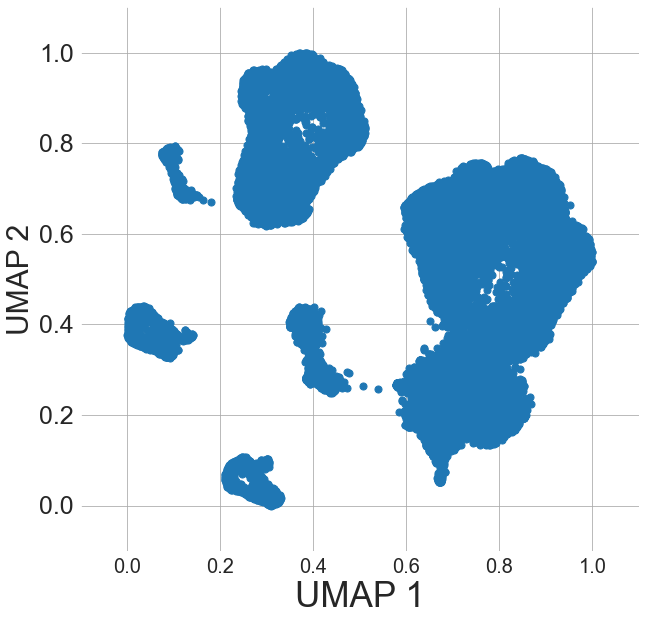

In [21]:
fig, ax = plt.subplots(1, 1,figsize=(10,10))
#plt.axis('off')
ax.set_facecolor('white')
plt.grid(color='#aaaaaa')


plt.scatter(mh[0],mh[1], s=50)

ax.tick_params(axis='y', which='major', labelsize=0)
ax.tick_params(axis='x', which='major', labelsize=0)

ax.set_xticks(np.linspace(0,1,6))
ax.set_xticklabels(['{:.1f}'.format(x) for x in np.linspace(0,1,6)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.xlim((-.1,1.1))
plt.xlabel('UMAP 1', fontsize=35)


ax.set_yticks(np.linspace(0,1,6))
ax.set_yticklabels(['{:.1f}'.format(x) for x in np.linspace(0,1,6)])
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25) 
    
plt.ylim((-.1,1.1))
plt.ylabel('UMAP 2', fontsize=30)

In [11]:
mapping=umap.UMAP(metric='mahalanobis', n_components=2, min_dist=.5, spread=2, n_neighbors=int(np.sqrt(tmp.shape[0])/2), \
                                n_epochs=1000, learning_rate=0.01, \
                                verbose=False, random_state=32)

mapping.fit(tmp.astype(float).values)
mh2=pd.DataFrame(mapping.transform(tmp.values), index=tmp.index)
mh2=(mh2-mh2.min())/(mh2.max()-mh2.min())

NameError: name 'tmp' is not defined

In [13]:
all_players.columns

Index(['player', 'season', 'birth_year', 'nationality', 'squad', 'league',
       'position', 'games', 'games_starts', 'minutes',
       ...
       'psxg', 'psnpxg_per_shot_on_target_against', 'psxg_net',
       'passes_pct_launched', 'pct_passes_launched', 'passes_length_avg',
       'pct_goal_kicks_launched', 'goal_kick_length_avg',
       'crosses_stopped_pct', 'avg_distance_def_actions'],
      dtype='object', length=172)

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(10,10))
#plt.axis('off')
ax.set_facecolor('white')
plt.grid(color='#aaaaaa')


plt.scatter(mh2[0],mh2[1], s=50)

ax.tick_params(axis='y', which='major', labelsize=0)
ax.tick_params(axis='x', which='major', labelsize=0)

ax.set_xticks(np.linspace(0,1,6))
ax.set_xticklabels(['{:.1f}'.format(x) for x in np.linspace(0,1,6)])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
plt.xlim((-.1,1.1))
plt.xlabel('UMAP 1', fontsize=35)


ax.set_yticks(np.linspace(0,1,6))
ax.set_yticklabels(['{:.1f}'.format(x) for x in np.linspace(0,1,6)])
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25) 
    
plt.ylim((-.1,1.1))
plt.ylabel('UMAP 2', fontsize=30)

In [ ]:
# OLD
#rc_out_feat=pd.read_hdf('/Users/federico comitani/GitHub/sodakick/data/rc_byfeature_lou_tpe3.h5')
dict_names={'0_0': 'ball control',
            '0_1': 'aggressivity',
            '0_2': 'goal keeping',
            '0_3': 'support',
            '0_4': 'goal keeping 2',
            '0_0_0': 'defense', #tackles
            '0_0_1': 'aerials', #and blocks, clearances
            '0_0_2': 'passes',
            '0_0_3': 'long passes',
            '0_0_4': 'fouls', #and pressure
            '0_0_5': 'direction', #carry+touches #ball controly this and 0_0 mobility
            '0_0_6': 'border control', #
            '0_0_7': 'short passes',
            '0_0_8': 'percent passes',
            '0_0_9': 'progressive actions',
            '0_1_0': 'aggressivity',
            '0_1_1': 'percent aggressivity',
            '0_1_0_0': 'fouled actions',
            '0_1_0_1': 'dribbles',
            '0_1_0_2': 'penalty area actions',
            '0_1_0_3': 'shots',
            '0_1_0_4': 'penalties',
            '0_2_0':   'saves gk',
            '0_2_1':   'actions against gk',
            '0_2_2':   'clean sheets gk',
            '0_2_3':   'penalties gk',
            '0_2_5':   'passes gk',
            '0_2_5':   'passes launched gk',
            '0_3_0':   'passes into penalty area',
            '0_3_1':   'assists',
            '0_3_0_0':   'shot creating actions',
            '0_3_0_0':   'passes into penalty area',
            '0_3_0_1':   'crosses area',
            '0_4_0':   'percent saves gk',
            '0_4_1':   'percent passes gk',        
           }